## Scatterplot smoothing by LOWESS

Demonstrates code used to perform scatterplot smoothing and confidence interval estimation in figure 3.

### Instructions

To run all code and open interactive figures, click Cell > Run all. Figures will appear when the entire script has finished running.

### Import packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.nonparametric.smoothers_lowess import lowess
import ipywidgets as widgets
%matplotlib notebook

### Import data

Demonstrating the analysis pipeline using the PAR-6 dosage vs 2-cell asymmetry dataset

<IPython.core.display.Javascript object>


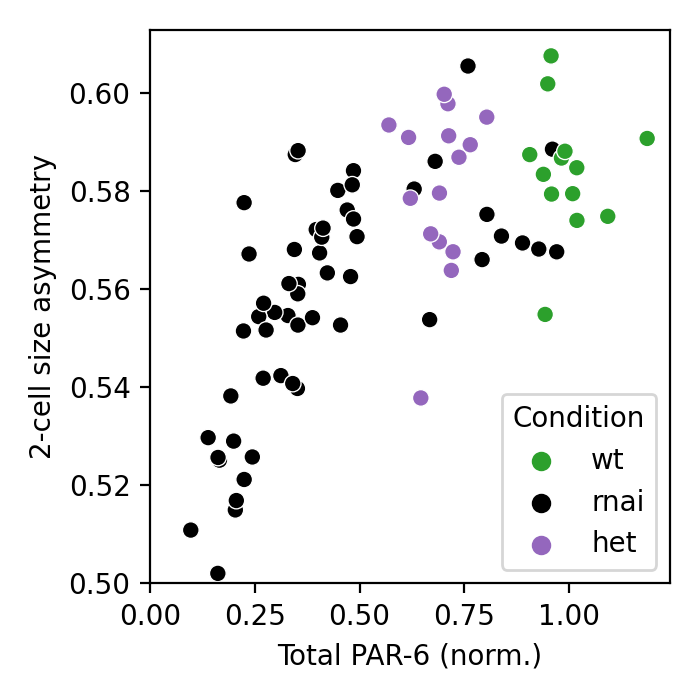

In [3]:
# Import data
df = pd.read_csv('../data/dosage_vs_2cellASI_par6.csv')

# Exclude entries with missing 2-cell ASI measurements
df = df[~df['2-cell asi'].isnull()]

# Plot
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='Dosage', y='2-cell asi', hue='Condition', ax=ax, palette=['tab:green', 'k', 'tab:purple'])
ax.set_xlabel('Total PAR-6 (norm.)')
ax.set_ylabel('2-cell size asymmetry')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

In [4]:
# Convert data to np arrays for analysis
xdata = df['Dosage'].to_numpy()
ydata = df['2-cell asi'].to_numpy()

### LOWESS fit

Using the lowess function from statsmodels. See documentation below:

In [5]:
help(lowess)

Help on function lowess in module statsmodels.nonparametric.smoothers_lowess:

lowess(endog, exog, frac=0.6666666666666666, it=3, delta=0.0, xvals=None, is_sorted=False, missing='drop', return_sorted=True)
    LOWESS (Locally Weighted Scatterplot Smoothing)
    
    A lowess function that outs smoothed estimates of endog
    at the given exog values from points (exog, endog)
    
    Parameters
    ----------
    endog : 1-D numpy array
        The y-values of the observed points
    exog : 1-D numpy array
        The x-values of the observed points
    frac : float
        Between 0 and 1. The fraction of the data used
        when estimating each y-value.
    it : int
        The number of residual-based reweightings
        to perform.
    delta : float
        Distance within which to use linear-interpolation
        instead of weighted regression.
    xvals: 1-D numpy array
        Values of the exogenous variable at which to evaluate the regression.
        If supplied, cannot us

The lowess function has a parameter 'frac' (default = 0.66) which controls the bias-variance tradeoff. An appropriate value should be set manually by comparing fits as a function of frac:

<IPython.core.display.Javascript object>


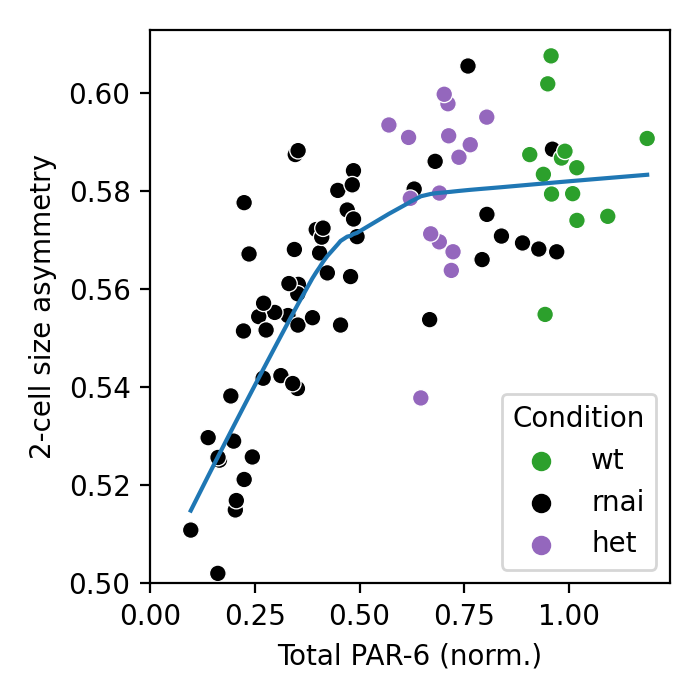

interactive(children=(FloatSlider(value=0.66, description='frac', max=1.0, step=0.01), Output()), _dom_classes…

In [6]:
def create_interactive_fig():
    fig, ax = plt.subplots()
    @widgets.interact(frac=(0, 1, 0.01))
    def update(frac=0.66): 
        ax.clear()
        sns.scatterplot(data=df, x='Dosage', y='2-cell asi', hue='Condition', ax=ax, 
                        palette=['tab:green', 'k', 'tab:purple'])
        res = lowess(ydata, xdata, frac=frac)
        ax.plot(res[:, 0], res[:, 1])
        ax.set_xlabel('Total PAR-6 (norm.)')
        ax.set_ylabel('2-cell size asymmetry')
        ax.set_ylim(bottom=0.5)
        ax.set_xlim(left=0)

    fig.set_size_inches(3.5, 3.5)
    fig.tight_layout()
    
create_interactive_fig()

Default value (0.66) looks reasonable

### Bootstrapping

In [7]:
# Specify parameters
frac = 0.66  ### <- LOWESS parameter as described in documentation above
n_bootstrap = 1000 ### <- number of bootstrap samples

# Perform bootstrapping
bootstrap_lowess = np.zeros([n_bootstrap, 100]) # empty results container
for i in range(n_bootstrap):  
    inds = np.random.choice(range(len(ydata)), len(ydata)) # selecting data (with replacement)
    res = lowess(ydata[inds], xdata[inds], xvals=np.linspace(0, 1.2, 100)) # performing LOWESS fit
    bootstrap_lowess[i, :] = res

<IPython.core.display.Javascript object>


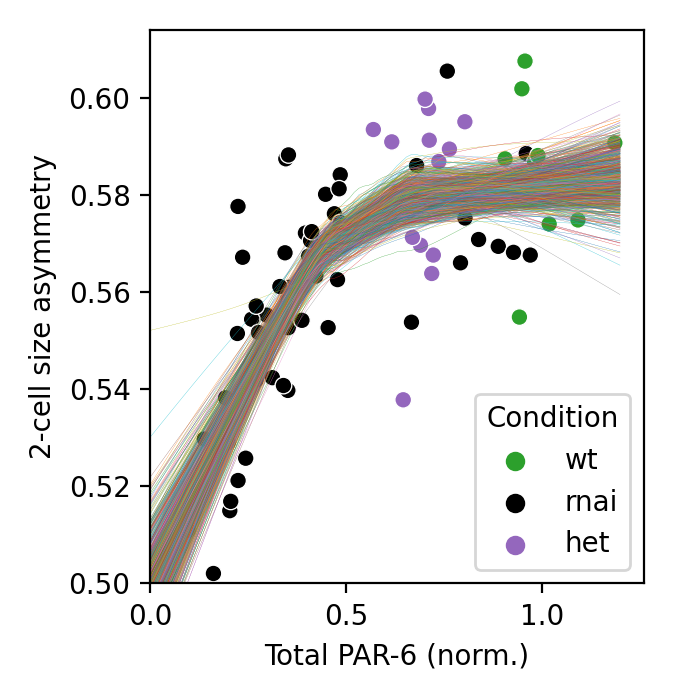

In [8]:
# Set up plot
fig, ax = plt.subplots()

# Plot scatter data
sns.scatterplot(data=df, x='Dosage', y='2-cell asi', hue='Condition', ax=ax, palette=['tab:green', 'k', 'tab:purple'])

# Plot bootstrap fits
for b in bootstrap_lowess:
    ax.plot(np.linspace(0, 1.2, 100), b, linewidth=0.1)
    
# Finalise figure
ax.set_xlabel('Total PAR-6 (norm.)')
ax.set_ylabel('2-cell size asymmetry')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()

### Calculate confidence interval

In [9]:
interval = 95 ### <- confidence interval to calculate

# Analyse full dataset
res_whole = lowess(ydata, xdata, xvals=np.linspace(0, 1.2, 100))

# Calculate confidence intervals from bootstrap data
res_lower = np.percentile(bootstrap_lowess, (100 - interval) / 2, axis=0)
res_upper = np.percentile(bootstrap_lowess, 50 + (interval / 2), axis=0)

<IPython.core.display.Javascript object>


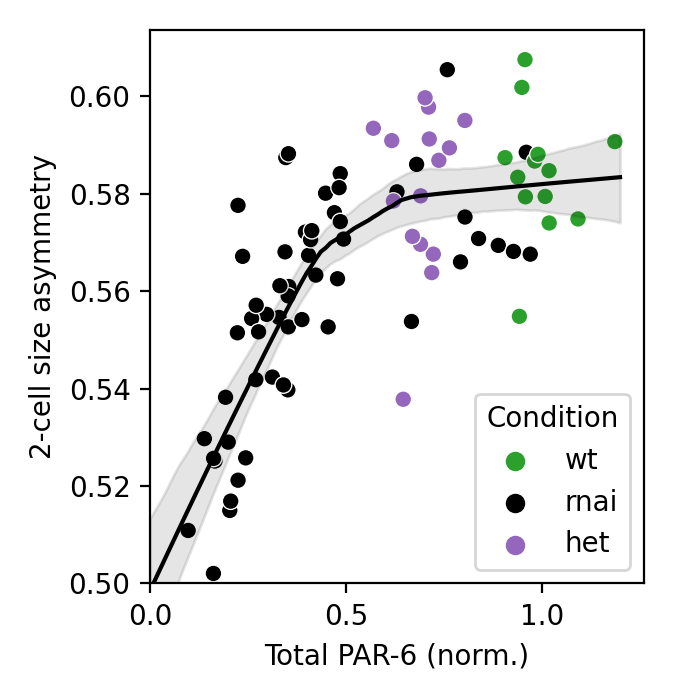

In [10]:
# Plot
fig, ax = plt.subplots()
sns.scatterplot(data=df, x='Dosage', y='2-cell asi', hue='Condition', ax=ax, 
               palette=['tab:green', 'k', 'tab:purple'])
ax.plot(np.linspace(0, 1.2, 100), res_whole, c='k')
ax.fill_between(np.linspace(0, 1.2, 100), res_lower, res_upper, alpha=0.1, color='k')
ax.set_xlabel('Total PAR-6 (norm.)')
ax.set_ylabel('2-cell size asymmetry')
ax.set_ylim(bottom=0.5)
ax.set_xlim(left=0)
fig.set_size_inches(3.5, 3.5)
fig.tight_layout()